# Anomaly Detection in Online Payment

#### Loading Libraries

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

#### Using Data from source: Kaggle

In [47]:
data = pd.read_csv('Fraud.csv')
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Explore

In [48]:
data.isnull().values.any()

False

#### Though there are no null values in the Fraud data

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#### The info() method provides a summary of the DataFrame's structure, including the column names, data types, memory usage, and the number of entries in the DataFrame.

In [50]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


#### The mean, count , standard deviation , minimum and maximum values of the data.


## Data Visualization

#### count the columns with different datatypes like Category, Integer, Float.

In [51]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))

Categorical variables: 3
Integer variables: 3
Float variables: 5


#### count the all features values

In [52]:
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


#### The count plot of the 'type' column using Seaborn library.

<Axes: xlabel='type', ylabel='count'>

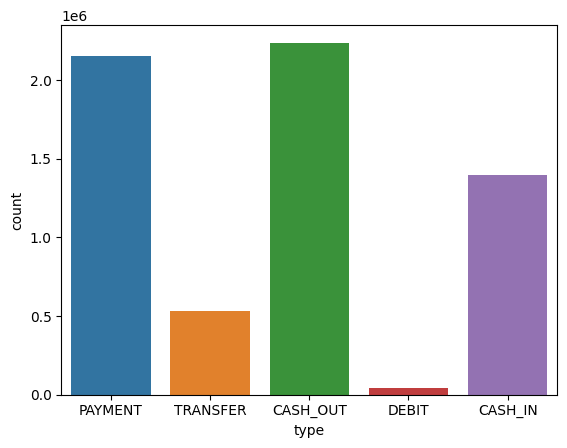

In [53]:
sns.countplot(x='type', data=data)

#### The bar plot for analyzing 'type' and 'amount' column simultaneously.

<Axes: xlabel='type', ylabel='amount'>

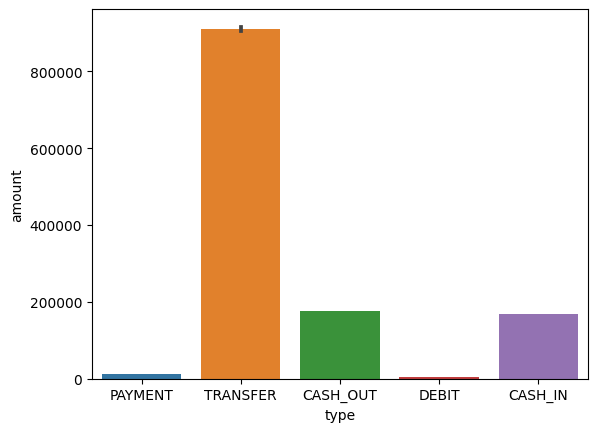

In [32]:
sns.barplot(x='type', y='amount', data=data)

####  Understanding the distribution of 'step' column

C:\Users\deepa\AppData\Local\Temp\ipykernel_3740\1113131929.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['step'], bins=50)


<Axes: xlabel='step', ylabel='Density'>

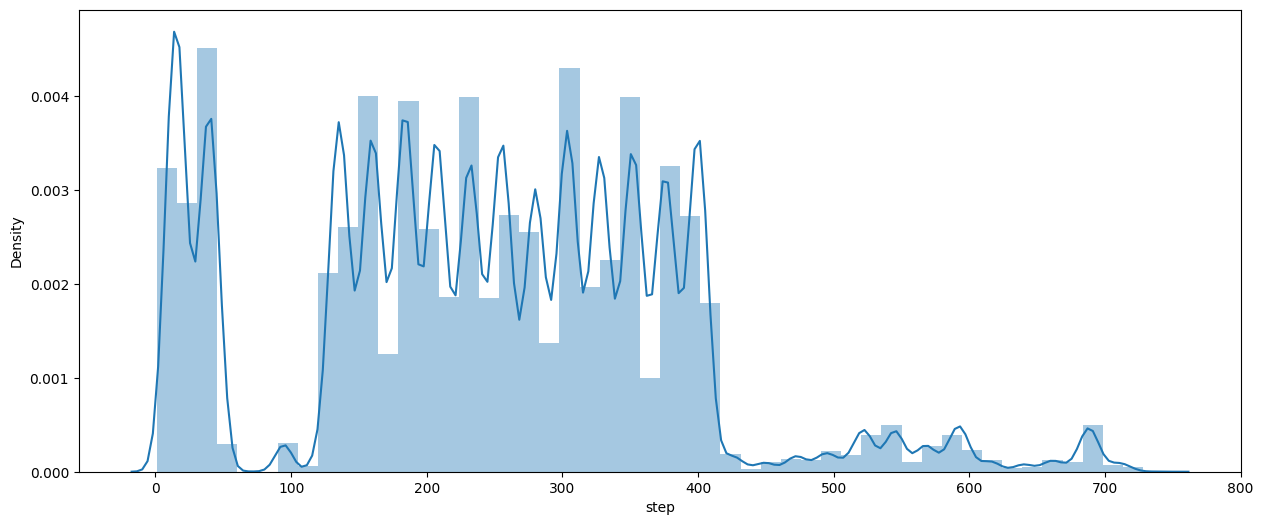

In [33]:
plt.figure(figsize=(15, 6))
sns.distplot(data['step'], bins=50)

#### The correlation among different columns using Heatmap.

<Axes: >

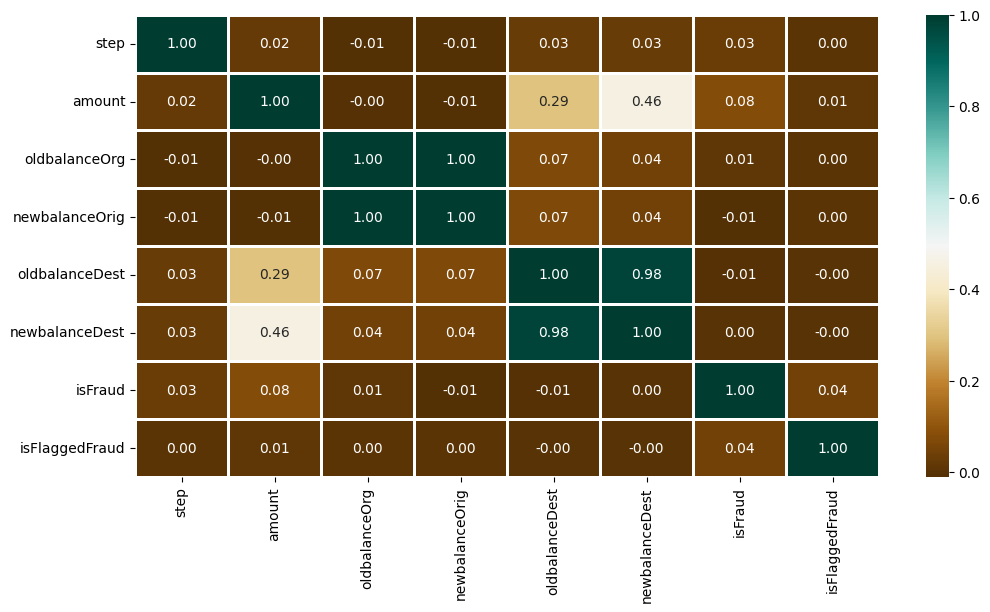

In [34]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(),
    cmap='BrBG',
    fmt='.2f',
    linewidths=2,
    annot=True)

## Data Preprocessing
### This step includes the following : 

##### 1. Encoding of 'type' column
##### 2. Dropping irrelevant columns like nameOrig, nameDest
##### 3. Data Splitting

In [35]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,1,0,0,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1,0,0,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,1


##### After the encoding, now we can drop the irrelevant columns.

In [36]:
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']

##### The shape of extracted data.

In [37]:
X.shape, y.shape

((6362620, 11), (6362620,))

#### Spliting the data into 2 parts : Training and Testing.

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

#### Model Training
#### As the prediction is a classification problem so the models we will be using are :

##### 1. LogisticRegression :  It predicts that the probability of a given data belongs to the particular category or not.
##### 2. XGBClassifier : It refers to Gradient Boosted decision trees. In this algorithm, decision trees are created in sequential form and weights are assigned to all the independent variables which are then fed into the decision tree which predicts results.
##### 3. DecisionTree:A decision tree is a hierarchical structure that uses a series of binary decisions to classify or predict outcomes based on input features.
##### 4.RandomForestClassifier : Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. Then, it collects the votes from different decision trees to decide the final prediction.

#### Accuarcy Comparison

LogisticRegression : 
Training Accuracy: 0.8874005925152822
Validation Accuracy: 0.8849976328503673
XGBClassifier : 
Training Accuracy: 0.9999817672497334
Validation Accuracy: 0.9994777637994892
DecisionTreeClassifier : 
Training Accuracy: 1.0
Validation Accuracy: 0.938739530393476
RandomForestClassifier : 
Training Accuracy: 0.9999992846155892
Validation Accuracy: 0.9635718404867615


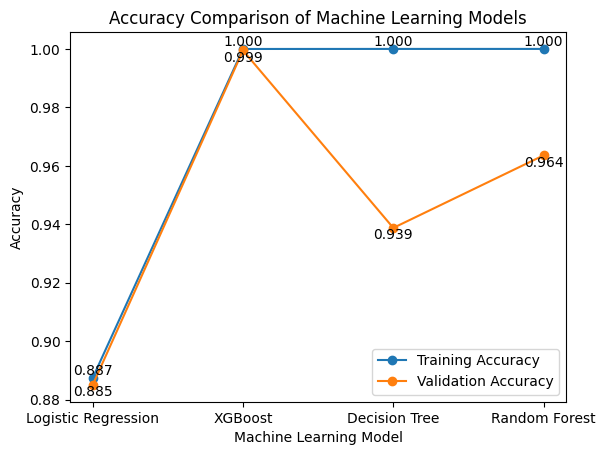

In [39]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

models = [
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

model_names = [
    'Logistic Regression',
    'XGBoost',
    'Decision Tree',
    'Random Forest'
]

train_accuracies = []
test_accuracies = []

for model in models:
    model.fit(X_train, y_train)
    print(f'{model.__class__.__name__} : ')

    train_preds = model.predict_proba(X_train)[:, 1]
    train_acc = roc_auc_score(y_train, train_preds)
    print('Training Accuracy:', train_acc)
    train_accuracies.append(train_acc)

    test_preds = model.predict_proba(X_test)[:, 1]
    test_acc = roc_auc_score(y_test, test_preds)
    print('Validation Accuracy:', test_acc)
    test_accuracies.append(test_acc)

# Plotting the accuracy comparison
plt.plot(model_names, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(model_names, test_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Machine Learning Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Machine Learning Models')
plt.legend()

# Adding data labels on the graph
for i, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies)):
    plt.text(model_names[i], train_acc, f'{train_acc:.3f}', ha='center', va='bottom')
    plt.text(model_names[i], test_acc, f'{test_acc:.3f}', ha='center', va='top')

plt.show()

#### Loss Comparison

LogisticRegression : 
Training Loss: 0.017828445607540908
Validation Loss: 0.017868092735069802
XGBClassifier : 
Training Loss: 0.00036556514895715915
Validation Loss: 0.0005942898422135732
DecisionTreeClassifier : 
Training Loss: 2.220446049250313e-16
Validation Loss: 0.010517844817459193
RandomForestClassifier : 
Training Loss: 0.000205156685228226
Validation Loss: 0.0039444069954548385


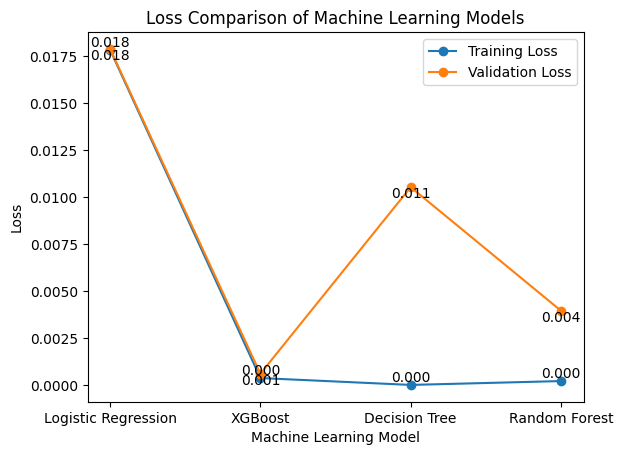

In [40]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss

models = [
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

model_names = [
    'Logistic Regression',
    'XGBoost',
    'Decision Tree',
    'Random Forest'
]

train_losses = []
test_losses = []

for model in models:
    model.fit(X_train, y_train)
    print(f'{model.__class__.__name__} : ')

    train_preds = model.predict_proba(X_train)[:, 1]
    train_loss = log_loss(y_train, train_preds)
    print('Training Loss:', train_loss)
    train_losses.append(train_loss)

    test_preds = model.predict_proba(X_test)[:, 1]
    test_loss = log_loss(y_test, test_preds)
    print('Validation Loss:', test_loss)
    test_losses.append(test_loss)

# Plotting the loss comparison
plt.plot(model_names, train_losses, marker='o', label='Training Loss')
plt.plot(model_names, test_losses, marker='o', label='Validation Loss')
plt.xlabel('Machine Learning Model')
plt.ylabel('Loss')
plt.title('Loss Comparison of Machine Learning Models')
plt.legend()

# Adding data labels on the graph
for i, (train_loss, test_loss) in enumerate(zip(train_losses, test_losses)):
    plt.text(model_names[i], train_loss, f'{train_loss:.3f}', ha='center', va='bottom')
    plt.text(model_names[i], test_loss, f'{test_loss:.3f}', ha='center', va='top')

plt.show()

##### Plotting the Confusion Matrix for all models

Logistic Regression : 
Confusion Matrix:
[[1904535    1816]
 [   1380    1055]]


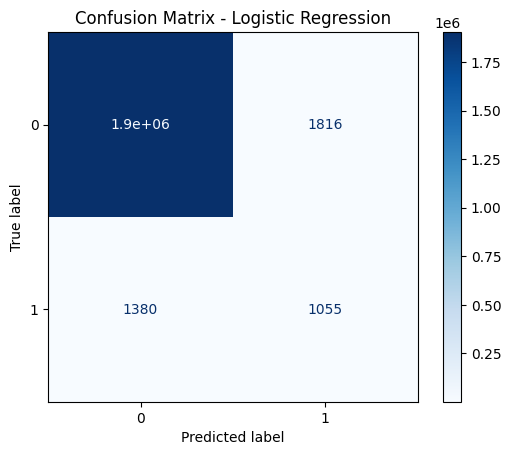

XGBoost : 
Confusion Matrix:
[[1906286      65]
 [    305    2130]]


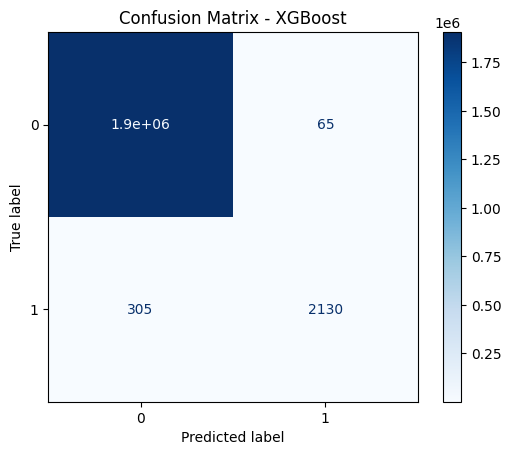

Decision Tree : 
Confusion Matrix:
[[1906098     253]
 [    301    2134]]


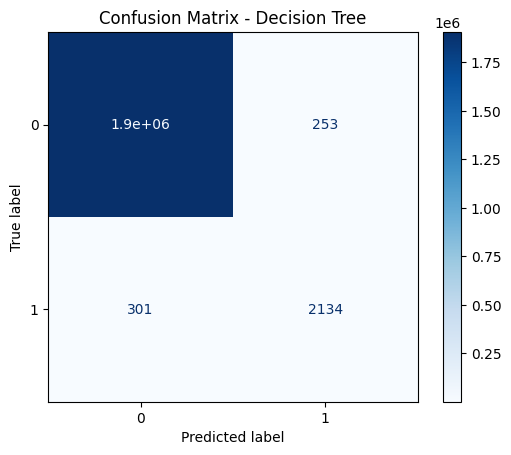

Random Forest : 
Confusion Matrix:
[[1906275      76]
 [    478    1957]]


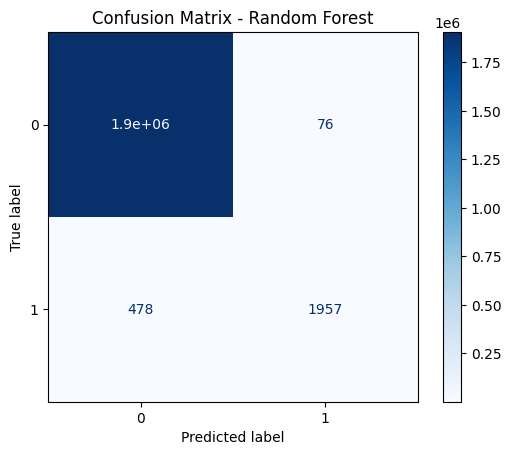

In [41]:
models = [
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

model_names = [
    'Logistic Regression',
    'XGBoost',
    'Decision Tree',
    'Random Forest'
]

for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)
    print(f'{model_name} : ')

    target_names = ["0", "1"]

    # Computing confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)

    # Displaying confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

## Calculating the Best Model Confusion Martix


Logistic Regression : 
Confusion Matrix:
[[1904535    1816]
 [   1380    1055]]
Accuracy: 0.9983256373422689
XGBClassifier : 
Confusion Matrix:
[[1906286      65]
 [    305    2130]]
Accuracy: 0.9998061595170962
Decision Tree : 
Confusion Matrix:
[[1906078     273]
 [    295    2140]]
Accuracy: 0.9997024286640829
Random Forest : 
Confusion Matrix:
[[1906275      76]
 [    478    1957]]
Accuracy: 0.9997097631688413


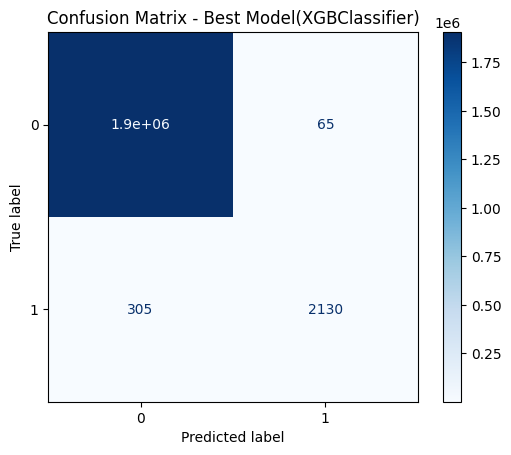

In [42]:


models = [
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

model_names = [
    'Logistic Regression',
    'XGBClassifier',
    'Decision Tree',
    'Random Forest'
]

best_accuracy = 0
best_model = None
best_model_cm = None

for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)
    print(f'{model_name} : ')

    # Computing confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)

    # Checking model which has the highest accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_name
        best_model_cm = cm

# Ploting the confusion matrix for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_model_cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Best Model({best_model})')
plt.show()


#### Performance Graph of each model

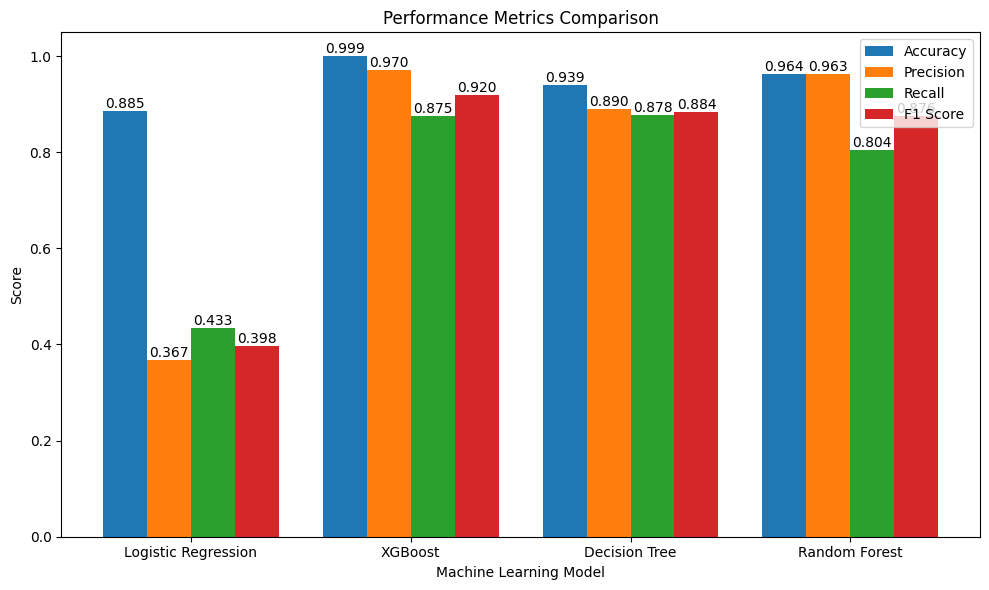

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

models = [
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

model_names = [
    'Logistic Regression',
    'XGBoost',
    'Decision Tree',
    'Random Forest'
]

train_accuracies = []
test_accuracies = []

for model in models:
    model.fit(X_train, y_train)

    train_preds = model.predict_proba(X_train)[:, 1]
    train_acc = roc_auc_score(y_train, train_preds)
    train_accuracies.append(train_acc)

    test_preds = model.predict_proba(X_test)[:, 1]
    test_acc = roc_auc_score(y_test, test_preds)
    test_accuracies.append(test_acc)

# Calculating precision, recall, and F1 score for each model
precisions = [precision_score(y_test, model.predict(X_test)) for model in models]
recalls = [recall_score(y_test, model.predict(X_test)) for model in models]
f1_scores = [f1_score(y_test, model.predict(X_test)) for model in models]

# Plotting the comparison
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x, test_accuracies, width, label='Accuracy')
bar2 = plt.bar(x + width, precisions, width, label='Precision')
bar3 = plt.bar(x + 2 * width, recalls, width, label='Recall')
bar4 = plt.bar(x + 3 * width, f1_scores, width, label='F1 Score')

plt.xlabel('Machine Learning Model')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + 1.5 * width, model_names)
plt.legend()

# Adding data labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.3f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)

plt.tight_layout()
plt.show()

### AUC score & ROC curve

Logistic Regression - AUC Score: 0.8810
XGBoost - AUC Score: 0.9992
Decision Tree - AUC Score: 0.9419
Random Forest - AUC Score: 0.9678


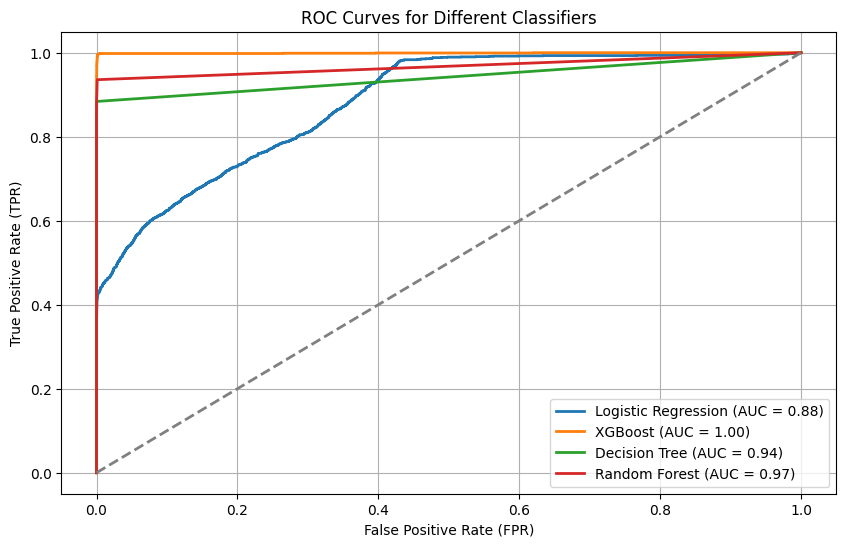

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

model_names = [
    'Logistic Regression',
    'XGBoost',
    'Decision Tree',
    'Random Forest'
]

plt.figure(figsize=(10, 6))

auc_scores = []  # Create an empty list to store AUC scores

for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc_score)  # Append the AUC score to the list
    print(f"{model_name} - AUC Score: {auc_score:.4f}")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Performance Table (Accuracy, Precision, Recall F1-score)

In [61]:
# Create a DataFrame to store the performance metrics
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': test_accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC Score': auc_scores
})

# Print the metrics table
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1 Score  AUC Score
0  Logistic Regression  0.884998   0.367468  0.433265  0.397663   0.880990
1              XGBoost  0.999478   0.970387  0.874743  0.920086   0.999169
2        Decision Tree  0.938945   0.890462  0.878029  0.884202   0.941914
3        Random Forest  0.963572   0.962617  0.803696  0.876007   0.967829


#### Best Performing Model

In [62]:
# Sort the DataFrame by Accuracy in descending order
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)

# Print the best model
best_model = sorted_metrics_df.iloc[0]['Model']
print("Best Model:", best_model)

Best Model: XGBoost
